In [37]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import seaborn as sns 
import matplotlib.pyplot as plt

import gensim
import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from gensim.models import Word2Vec

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# from numpy import random

%matplotlib inline
np.random.seed(500)

In [38]:
df = pd.read_csv("..//data//Womens Clothing E-Commerce Reviews Sentiment v2.csv")

In [41]:
import multiprocessing
from gensim.models import Doc2Vec

cores = multiprocessing.cpu_count()

In [15]:
from gensim.models import Word2Vec
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
word2vec.init_sims(replace=True)

In [32]:
from itertools import islice
list(islice(word2vec.vocab, 0, 30))

['</s>',
 'in',
 'for',
 'that',
 'is',
 'on',
 '##',
 'The',
 'with',
 'said',
 'was',
 'the',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'are',
 'I',
 'have',
 'he',
 'will',
 'has',
 '####',
 'his',
 'an',
 'this',
 'or']

In [33]:
## MANDATORY FOR WORD2VEC EMBEDDING
## [EMBEDDING] Get Word2Vec values for a Tweet

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions_tokens, generate_missing=False):
    embeddings = clean_questions_tokens.apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))
    return list(embeddings)

# Call the functions
embeddings = get_word2vec_embeddings(word2vec, df.processed_Review_text, True)

print ('[EMBEDDING] Get Word2Vec values for a text')

[EMBEDDING] Get Word2Vec values for a Tweet


In [34]:
np.array(embeddings).shape

(22641, 300)

In [ ]:

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(embeddings, list_labels, 
                                                                    test_size=0.2, random_state=40)

w2v = dict()
w2v["train"] = (X_train_w2v, y_train_w2v)
w2v["test"]  = (X_test_w2v, y_test_w2v)

print ('DONE - [CLASSIFY] Word2Vec Train Test Split]')

In [9]:
def renames(feature, values):
    Dict_cols={}
    for value in values:
        Dict_cols[value]=feature+value
    return Dict_cols

In [10]:
## Encoding a categorical column
column_name='Division Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Division_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Division_columns)

column_name='Department Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Department_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Department_columns)

column_name='Class Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Class_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Class_columns)

In [11]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'processed_Review_text', 'PA_Polarity',
       'PA_Subjectivity', 'Division Name_General',
       'Division Name_General Petite', 'Division Name_Initmates',
       'Department Name_Bottoms', 'Department Name_Dresses',
       'Department Name_Intimate', 'Department Name_Jackets',
       'Department Name_Tops', 'Department Name_Trend', 'Class Name_Blouses',
       'Class Name_Casual bottoms', 'Class Name_Chemises',
       'Class Name_Dresses', 'Class Name_Fine gauge', 'Class Name_Intimates',
       'Class Name_Jackets', 'Class Name_Jeans', 'Class Name_Knits',
       'Class Name_Layering', 'Class Name_Legwear', 'Class Name_Lounge',
       'Class Name_Outerwear', 'Class Name_Pants', 'Class Name_Shorts',
       'Class Name_Skirts', 'Class Name_Sleep', 'Class Name_Sweaters',
       'Class Name_Swim', 'Class Name_Trend'],


In [12]:
## Discarding a empty reviews & removing the other columns

df=df[((df.processed_Review_text.isna()==False) & (df.processed_Review_text.isnull()==False) & (df.processed_Review_text!=""))]

In [46]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [45]:
tqdm(df.processed_Review_text)

  0%|          | 0/23486 [00:00<?, ?it/s]

  0%|          | 0/23486 [00:00<?, ?it/s]

In [44]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(df.processed_Review_text)])

100%|██████████| 23486/23486 [00:00<00:00, 1089129.69it/s]


AttributeError: 'str' object has no attribute 'words'

In [14]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
df_tokenized = df.apply(lambda r: w2v_tokenize_text(df.processed_Review_text), axis=1).values

df_word_average = word_averaging_list(wv,df_tokenized)

TypeError: ('expected string or bytes-like object', 'occurred at index 0')

In [7]:
# # TF IDF Conversion
# vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=21448)
# review_vectors = vectorizer.fit_transform(df["processed_Review_text"])
# features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())
# review_columns= vectorizer.get_feature_names()

In [8]:
# # TF IDF Conversion
vectorizer = TfidfVectorizer()
review_vectors = vectorizer.fit_transform(df["processed_Review_text"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())
review_columns= vectorizer.get_feature_names()

In [9]:
features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df=pd.concat([df,features_df], axis=1,ignore_index=False)

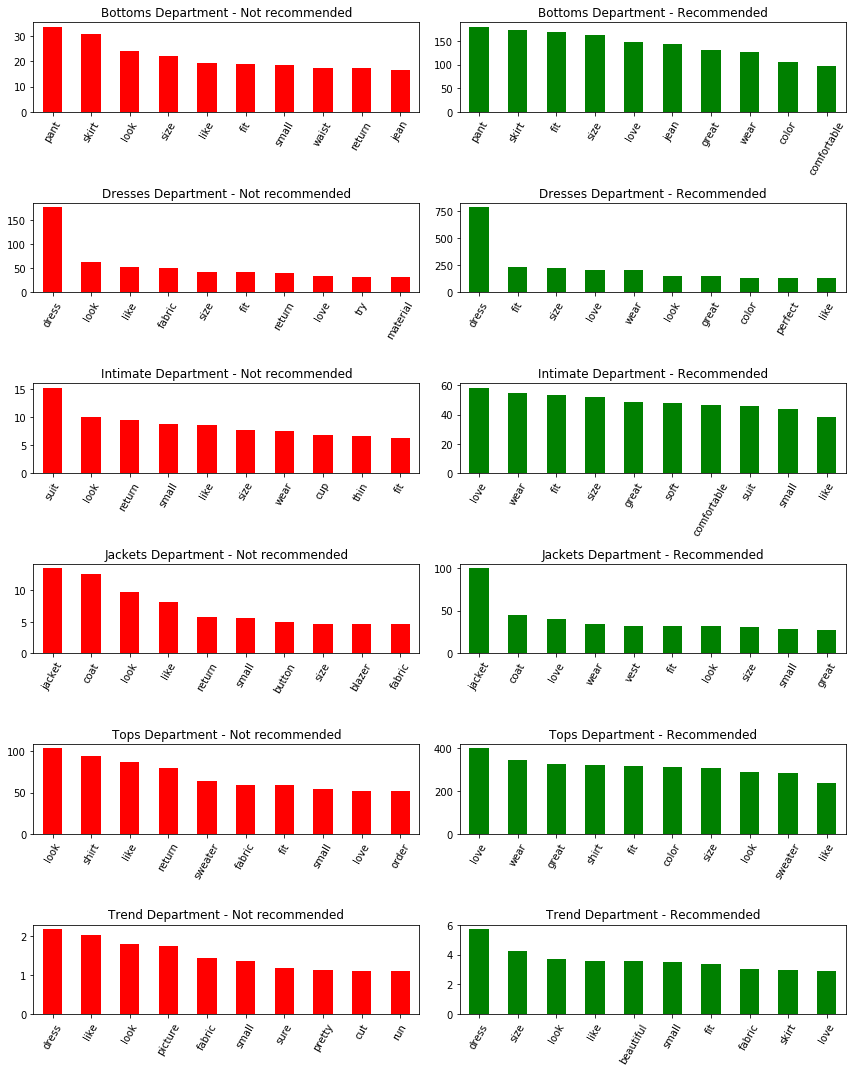

In [10]:
wordslist=df.columns.tolist()[42:]

plt.subplots(figsize=(12,15))  
i=1
for (d,r),bucket in df.groupby(['Department Name','Recommended IND']):
    
    plt.subplot(6,2,i)
    if r==0:
        bucket[wordslist].sum().sort_values(ascending=False).head(10).plot(kind='bar',color='red')
        plt.title(d+' Department - Not recommended')
    else:
        bucket[wordslist].sum().sort_values(ascending=False).head(10).plot(kind='bar',color='green')
        plt.title(d+' Department - Recommended')
    plt.xticks(rotation=60)
    
    i=i+1
    plt.tight_layout()

In [11]:
df=df.drop(columns=['Clothing ID','Title','Division Name', 'Department Name', 'Class Name','Positive Feedback Count','Review Text','processed_Review_text'])

In [12]:
InputFeature=df.columns.tolist()
OutputFeature='Recommended IND'
InputFeature.remove(OutputFeature)

In [45]:
## For Hyper parameter selection used Grid Search

def param_selection(model,param_grid,InputFeatureData,OutputFeatureData, nfolds=3):
#     print(str(datetime.datetime.now())+" : Starting Param selection")
    grid_search = GridSearchCV(model, param_grid, cv=nfolds,verbose =1)
    grid_search.fit(InputFeatureData,OutputFeatureData)
    print("Best Parmater for model : "+ str(grid_search.best_params_))
#     print(str(datetime.datetime.now())+" : Param selection is completed")
    return grid_search.best_estimator_

def Category_coefs(modelbest_estimator,columnslist, ImpFtrShow, label, subplotnbr):
        
    if type(modelbest_estimator).__name__=='LogisticRegression':
        if(subplotnbr>0):
            plt.subplot(2,2,subplotnbr);
        
        # Coeffiencents
        coefs=pd.DataFrame({'Featrures':InputFeature, 'Coeff':modelbest_estimator.coef_[0]})
        coefs=coefs[coefs['Featrures'].isin(columnslist)]
        if ImpFtrShow==0 or ImpFtrShow*2>len(coefs['Featrures']) :
            coefs=coefs.sort_values(by=['Coeff'],ascending=False)
            title= label+' Features of Coeff''s '
        else:
            ## Accounting both positive & negative important coefficients
            coefs=pd.concat([coefs.sort_values(by=['Coeff'],ascending=False).head(ImpFtrShow),coefs.sort_values(by=['Coeff'],ascending=True).tail(ImpFtrShow)])
            title='Top & Bottom '+str(ImpFtrShow*2)+' '+label+' Features of Coeff''s '
        plt.bar(coefs['Featrures'], coefs['Coeff']);
        plt.title(title)
        plt.xticks(rotation=70)
    
    elif type(modelbest_estimator).__name__=='MultinomialNB':
        
        # feature_log_prob_
        pred1=pd.DataFrame({'Featrures':InputFeature, 'prob':modelbest_estimator.feature_log_prob_[1]})
        pred0=pd.DataFrame({'Featrures':InputFeature, 'prob':modelbest_estimator.feature_log_prob_[0]})
        
        pred0=pred0[pred0['Featrures'].isin(columnslist)]
        pred1=pred1[pred1['Featrures'].isin(columnslist)]
        
        if ImpFtrShow==0 or ImpFtrShow*2>len(pred0['Featrures'])  :
            pred0=pred0.sort_values(by=['prob'],ascending=False)
            pred1=pred1.sort_values(by=['prob'],ascending=False)
            title= label+' Features of log probablity '
        else:
            pred0=pred0.sort_values(by=['prob'],ascending=False).head(ImpFtrShow)
            pred1=pred1.sort_values(by=['prob'],ascending=False).head(ImpFtrShow)
            title='Top '+str(ImpFtrShow)+' '+label+' Features of log probablity'
        
        if(subplotnbr==0):
            plt.subplot(1,2,1)
            plt.bar(pred0['Featrures'], pred0['prob'], color='red');
            plt.title(title+ ' for NonRec')
            plt.xticks(rotation=70)
            plt.subplot(1,2,2)
            plt.bar(pred1['Featrures'], pred1['prob'], color='green');
            plt.title(title+ ' for Rec')
            plt.xticks(rotation=70)
        else:
            plt.subplot(4,4,(subplotnbr*2)-1)
            plt.bar(pred0['Featrures'], pred0['prob'], color='red');
            plt.title(title)
            plt.xticks(rotation=70)
            plt.subplot(4,4,(subplotnbr*2))
            plt.bar(pred1['Featrures'], pred1['prob'], color='green');
#             plt.title(title+ ' for Rec')
            plt.xticks(rotation=70)
    
    elif type(modelbest_estimator).__name__=='RandomForestClassifier':
        if(subplotnbr>0):
            plt.subplot(2,2,subplotnbr);
        
        # Important Features
        coefs=pd.DataFrame({'Featrures':InputFeature, 'Coeff':modelbest_estimator.feature_importances_})
        coefs=coefs[coefs['Featrures'].isin(columnslist)]
        if ImpFtrShow==0 or ImpFtrShow*2>len(coefs['Featrures']) :
            coefs=coefs.sort_values(by=['Coeff'],ascending=False)
            title= label+' Important Features '
        else:
            coefs=coefs.sort_values(by=['Coeff'],ascending=False).head(ImpFtrShow*2)
            title='Top  '+str(ImpFtrShow*2)+' '+label+' Important Features '
        plt.bar(coefs['Featrures'], coefs['Coeff']);
        plt.title(title)
        plt.xticks(rotation=70)

def validation(modelbest_estimator,InputFeatureData,OutputFeatureData, X_train, X_test, y_train, y_test, datetime_modelfit,nfolds):
    plt.subplots(figsize=(10,4))
    if len(X_train)==0:
        X_train, X_test, y_train, y_test = train_test_split(InputFeatureData,OutputFeatureData,  test_size=0.2, random_state=0)
        
    if nfolds<=1 :
        ## Holdout validation
        y_pred = modelbest_estimator.predict(X_test)
        y=y_test
        print('Accuracy Score : '+str(metrics.accuracy_score(y,y_pred )))
        print('precision  : '+str(metrics.precision_score(y,y_pred ))) 
        print('recall  : '+str(metrics.recall_score(y,y_pred ))) 
        print('AUC  : '+str(metrics.roc_auc_score(y, y_pred)))
    else:
        ## Cross fold Validation 
        
        scores=cross_val_score(modelbest_estimator, InputFeatureData,OutputFeatureData, cv=nfolds, scoring="accuracy")
        plt.subplot(1,2,1)
        pd.Series(scores).plot(kind="box", label="Accuracy");
        plt.title('RMSE from '+str(nfolds)+' Folds')

        print("Cross Validation Accuracy Scores "+str(scores))
        print("Cross Validation Accuracy Mean Score "+str(np.mean(scores, dtype=np.float64)))
        
        scores=cross_val_score(modelbest_estimator,InputFeatureData,OutputFeatureData, cv=nfolds, scoring="precision")
        print("Cross Validation Accuracy precision Score "+str(np.mean(scores, dtype=np.float64)))

        datetime_cv=datetime.datetime.now()
        minutes_diff = round((datetime_cv - datetime_modelfit).total_seconds() / 60.0,2)
        print("Model Cross Validation completed in "+ str(minutes_diff) + " minutes ")

        ## Validating the model
        y_pred = modelbest_estimator.predict(InputFeatureData)
        y=OutputFeatureData
        
    ## Confusion Matrix 
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d',xticklabels=['No','Yes'], yticklabels=['No','Yes'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


def model_experiment(model,param_grid,InputFeatureData,OutputFeatureData, nfolds=[3,3], ImpFtrShow=3):
    ## Parameters ##
    ## model - Input model
    ## param_grid - model parameters in dict type to find best one, if no need to find - pass empty dict value
    ## nfolds - 1st value :GridSearchCV nfold value, 2nd value - Cross Validation nfold value. if you want to proceed with holdout validation, pass 0 in 2nd parameter
    ## ImpFtrShow - Number of attribute to show
    
    print("*******", type(model).__name__,"*****")
    
    InputFeatureData['PA_Polarity'] = (InputFeatureData['PA_Polarity'] +1 )/2
    
    datetime_start=datetime.datetime.now()
    
    print(str(datetime.datetime.now())+" : Starting the model experiments")
    if len(param_grid)==0:
        ## Spliting the train & test data
        X_train, X_test, y_train, y_test = train_test_split(InputFeatureData,OutputFeatureData,  test_size=0.2, random_state=0)
        
        # Fitting a model based on given parameter
        modelbest_estimator=model
        modelbest_estimator.fit(X_train,y_train)
        
        datetime_modelfit=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model Fitting completed in "+ str(minutes_diff) + " minutes ")
        validation(modelbest_estimator,InputFeatureData,OutputFeatureData, X_train, X_test, y_train, y_test,datetime_modelfit, nfolds[1])
    
    else:
        ## Experimenting model with different parameters
        modelbest_estimator=param_selection(model,param_grid,InputFeatureData,OutputFeatureData,nfolds[0])
        
        datetime_modelfit=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model GridSearch CV completed in "+ str(minutes_diff) + " minutes ")
        
        validation(modelbest_estimator,InputFeatureData,OutputFeatureData, [],[],[],[],datetime_modelfit, nfolds[1])
  
    if type(model).__name__ in ('LogisticRegression','MultinomialNB','RandomForestClassifier'):
        
        # Important Features for all
        plt.subplots(figsize=(12,4))
        Category_coefs(modelbest_estimator,df.columns,ImpFtrShow*2,'All',0)
        plt.tight_layout()
        
        if type(model).__name__=='MultinomialNB':
            plt.subplots(figsize=(15,15))   
        else:
            plt.subplots(figsize=(12,8))
        # Important Features for each catefory
        #plt.subplot(2,2,1)
        Category_coefs(modelbest_estimator,df.columns[df.columns.isin(list(Division_columns.values()))],ImpFtrShow,'Division',1)
        #plt.subplot(2,2,2)
        Category_coefs(modelbest_estimator,df.columns[df.columns.isin(list(Department_columns.values()))],ImpFtrShow,'Department',2)
        #plt.subplot(2,2,3)
        Category_coefs(modelbest_estimator,df.columns[df.columns.isin(list(Class_columns.values()))],ImpFtrShow,'Class',3)
        #plt.subplot(2,2,4)
        Category_coefs(modelbest_estimator,df.columns[df.columns.isin(review_columns)],ImpFtrShow, 'Reviews',4)
        plt.tight_layout()
    

******* LogisticRegression *****


C:\Users\bsubramani\AppData\Local\Continuum\anaconda2\envs\snakes\lib\site-packages\ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2019-08-23 23:54:35.498983 : Starting the model experiments
Model Fitting completed in 0.26 minutes 
Accuracy Score : 0.9337602119673217
precision  : 0.955930359085963
recall  : 0.9622124863088719
AUC  : 0.8887459238841965


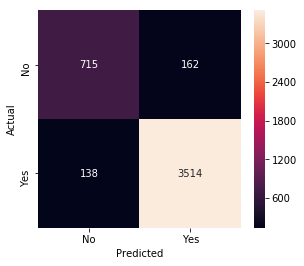

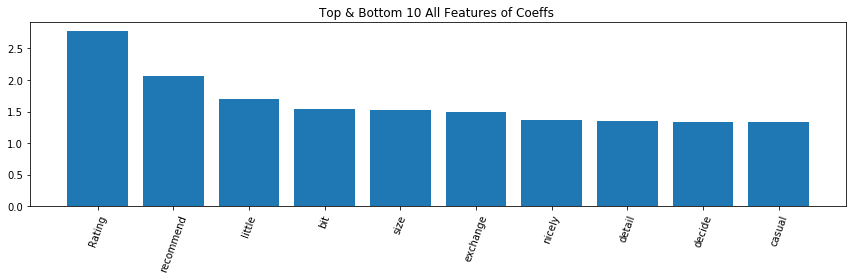

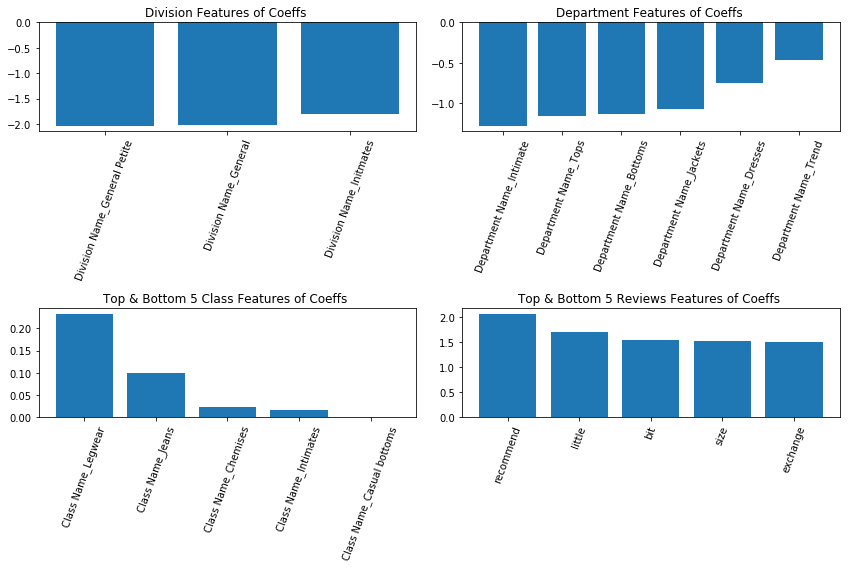

In [33]:
model=linear_model.LogisticRegression(n_jobs=1, solver='liblinear', C=1, penalty='l2', max_iter=1000)
param_grid={}#{'C':[0.01,1,100,1000]} 

model_experiment(model,param_grid,df[InputFeature], df[OutputFeature],[2,0],5)

******* MultinomialNB *****


C:\Users\bsubramani\AppData\Local\Continuum\anaconda2\envs\snakes\lib\site-packages\ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2019-08-23 23:56:53.144963 : Starting the model experiments
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.2s finished


Best Parmater for model : {'alpha': 0.1}
Model GridSearch CV completed in 0.52 minutes 
Accuracy Score : 0.9169794656657099
precision  : 0.9140546006066734
recall  : 0.9901423877327492
AUC  : 0.8012285484843905


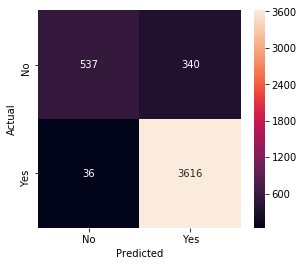

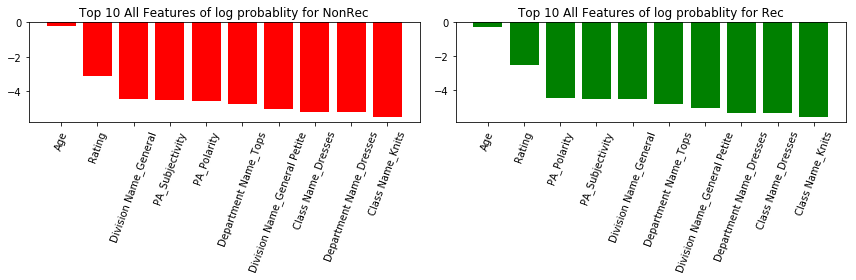

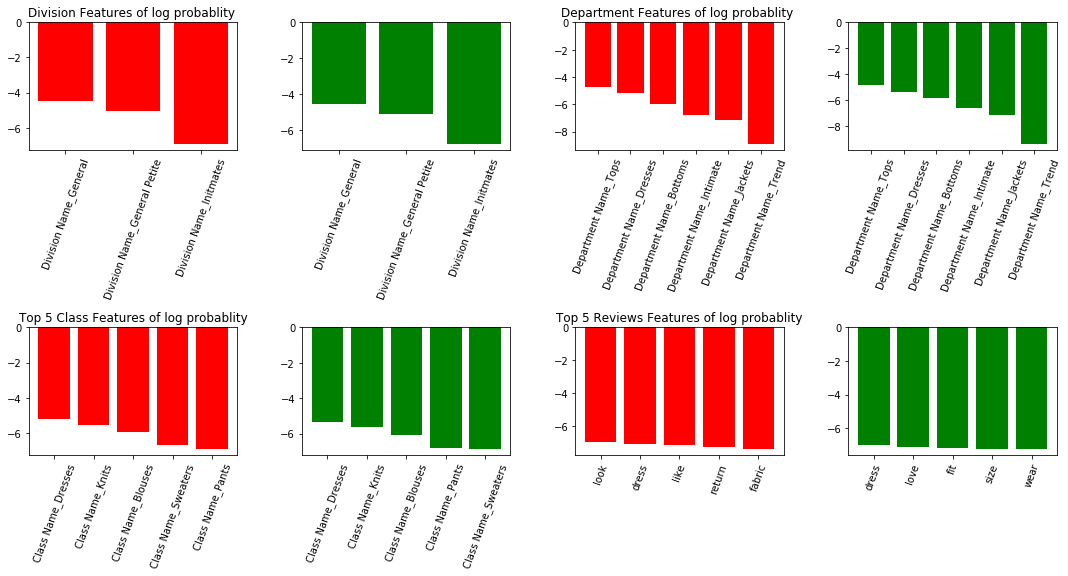

In [36]:
# fit the training dataset on the NB classifier
Naive = MultinomialNB(alpha=0.1)
param_grid={'alpha':np.linspace(0.1,1,2)} #{'alpha':np.linspace(0,1,5)} 

model_experiment(Naive,param_grid,df[InputFeature], df[OutputFeature],[2,1],5)

******* RandomForestClassifier *****


C:\Users\bsubramani\AppData\Local\Continuum\anaconda2\envs\snakes\lib\site-packages\ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2019-08-24 00:11:15.505171 : Starting the model experiments
Model Fitting completed in 0.57 minutes 
Cross Validation Accuracy Scores [0.92579833 0.92924341 0.92341328]
Cross Validation Accuracy Mean Score 0.9261516717459477
Cross Validation Accuracy precision Score 0.9221230743414845
Model Cross Validation completed in 3.48 minutes 


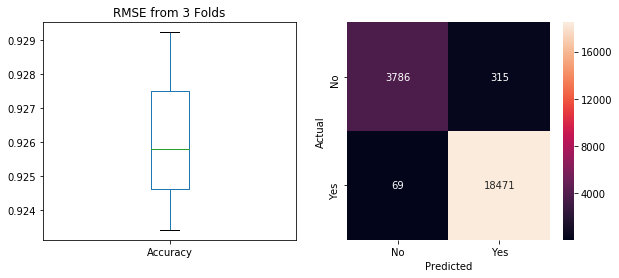

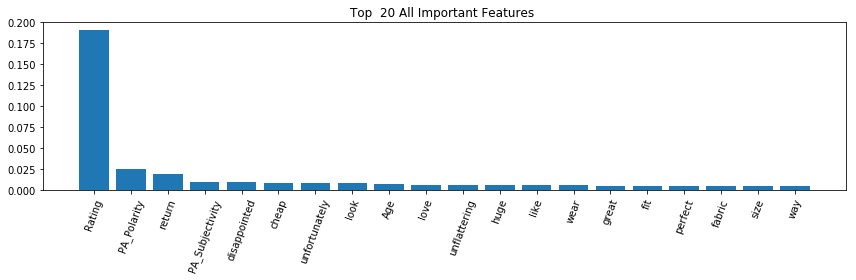

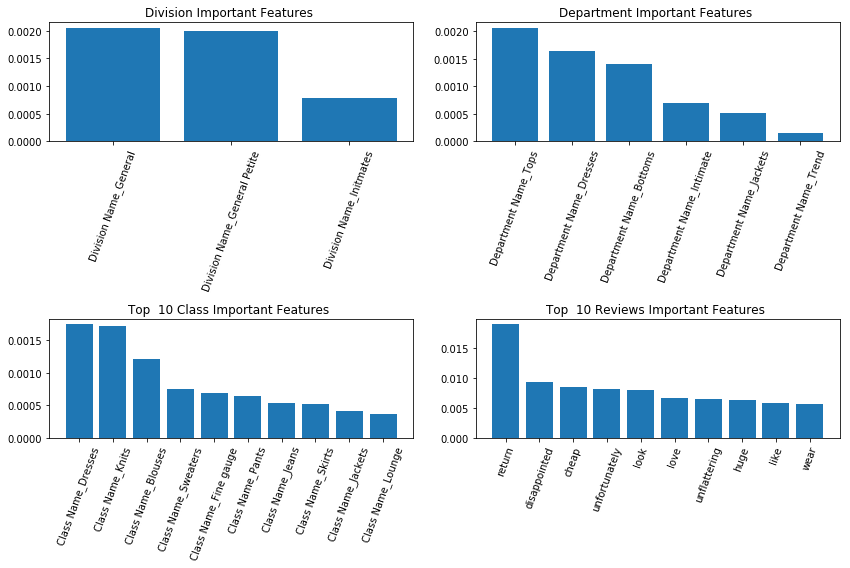

In [46]:
RDF = RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1)
param_grid={}

model_experiment(RDF,param_grid,df[InputFeature], df[OutputFeature],[2,3],5)

******* SVC *****


C:\Users\bsubramani\AppData\Local\Continuum\anaconda2\envs\snakes\lib\site-packages\ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2019-08-24 00:18:22.190607 : Starting the model experiments
Model Fitting completed in 62.86 minutes 
Accuracy Score : 0.9344226098476485
precision  : 0.9640387275242047
recall  : 0.9542716319824753
AUC  : 0.9030195104040085


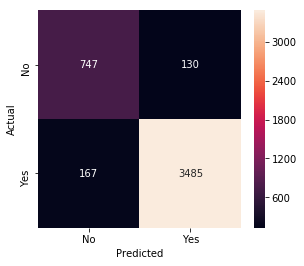

In [48]:
modelSVC=SVC(C=10,  gamma=0.1, kernel='rbf')
param_grid={}
model_experiment(modelSVC,param_grid,df[InputFeature], df[OutputFeature],[2,1],5)